In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [ ]:
basedir = 'D:/lalamove/lalamove/data/Clean_1s_all_240103/train'
labels = [5, 6, 7]
with open(basedir + '/../data_split_params.json', 'r') as file:
    features = json.load(file)['FEATURES']
print(features)

In [ ]:
label = 5

In [41]:
y = pd.read_csv(basedir + f'/{label}/train_label_{label}.csv')
X = []
step = 30_000
for i in range(np.ceil(len(y)/30_000).astype(int)):
    temp = pd.read_csv(basedir + f'/{label}/extract_features_{label}_{i}.csv', index_col=0)
    X.append(temp)
X = pd.concat(X)
assert len(X) == len(y), f"Length mismatch {len(X)}, {len(y)}"

In [42]:
X.shape, y.shape

((381607, 500), (381607, 6))

In [54]:
dates = y.date.unique()
chosen = dates[-3]
test_idx = y[(y.date == chosen) & (y.type == 0)].index
train_idx = y[(y.date != chosen) & (y.type == 0)]
train_idx_add = y[(y.date != chosen) & (y.type == 1)].sample(frac=0.8)
train_idx = pd.concat([train_idx, train_idx_add]).index
# train_idx = y[(y.date != chosen)].index

X_train_, X_test_ = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx].label, y.iloc[test_idx].label

In [55]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_)
X_test = scaler.transform(X_test_)

# X_train = X_train.reshape(-1, 20, 25)
# X_test = X_test.reshape(-1, 20, 25)

In [56]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, Dense, BatchNormalization, Activation, GlobalAveragePooling1D, Dropout

In [57]:
# Simple ANN
inputs = Input(shape=X_train.shape[-1])
x = Dense(200, activation='relu')(inputs)
x = Dense(200, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(200, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500)]             0         
                                                                 


 dense_18 (Dense)            (None, 200)               100200    
                                                                 
 dense_19 (Dense)            (None, 200)               40200     
                                                                 
 dropout_9 (Dropout)         (None, 200)               0         
                                                                 
 dense_20 (Dense)            (None, 200)               40200     
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_21 (Dense)            (None, 200)               40200     
                                                                 
 dropout_11 (Dropout)        (None, 200)               0         
                                                                 
 dense_22 (Dense)            (None, 200)               40200     
          

In [58]:
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy(name='acc'),
                       Precision(name='precision'),
                       Recall(name='recall')])

history = model.fit(X_train, y_train, batch_size=256, epochs=30, validation_data=(X_test, y_test),)
                    # callbacks=[EarlyStopping(patience=5,
                    #                    min_delta=0.0005,
                    #                    restore_best_weights=True)])

Epoch 1/30
1317/1317 [==============================] - 4s 3ms/step - loss: 0.0957 - acc: 0.9684 - precision: 0.9793 - recall: 0.9074 - val_loss: 0.0932 - val_acc: 0.9798 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
1317/1317 [==============================] - 8s 6ms/step - loss: 0.0566 - acc: 0.9853 - precision: 0.9952 - recall: 0.9526 - val_loss: 0.0880 - val_acc: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
1317/1317 [==============================] - 8s 6ms/step - loss: 0.0529 - acc: 0.9859 - precision: 0.9958 - recall: 0.9543 - val_loss: 0.0877 - val_acc: 0.9799 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
1317/1317 [==============================] - 7s 6ms/step - loss: 0.0506 - acc: 0.9863 - precision: 0.9963 - recall: 0.9553 - val_loss: 0.0811 - val_acc: 0.9797 - val_precision: 0.0833 - val_recall: 0.0037
Epoch 5/30
1317/1317 [==============================] - 11s 8ms/step - loss: 0.0485 - acc: 0.9867 - precision: 0

427/427 [==============================] - 1s 2ms/step
(13649, 1) (13649,)
type
True Positive        12
True Negative     13359
False Positive       23
False Negative      255
Name: count, dtype: int64


Text(0.5, 1.0, "['z_gyro_clean', 'y_gyro_clean', 'x_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'acceleration', 'speed_kmh']")

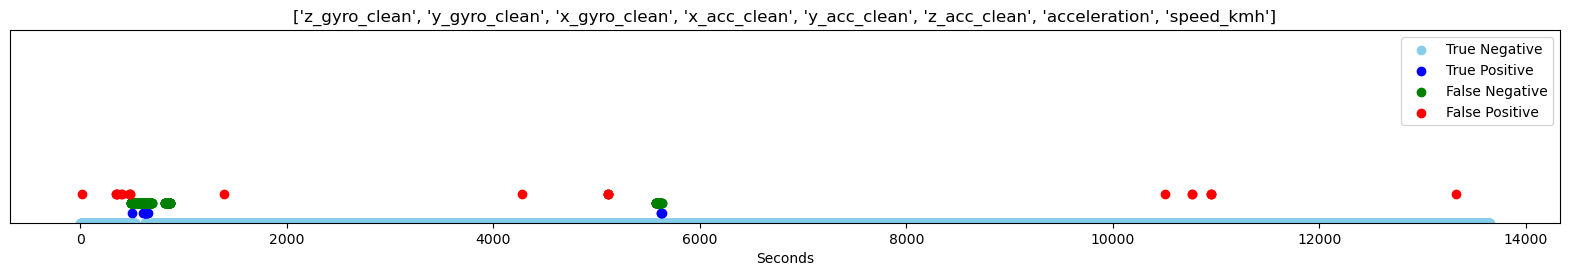

In [59]:
pred = model.predict(X_test) >= 0.5
print(pred.shape, y_test.shape)

df = pd.DataFrame(np.hstack((y_test.to_numpy().reshape(-1, 1), pred)), columns=['true', 'pred'])
df.pred = df.pred.astype(int)

def classify(row):
    true, pred = row.true, row.pred
    if true == pred and true == 0:
        return 'True Negative'
    elif true == pred and true == 1:
        return 'True Positive'
    elif true != pred and true == 0:
        return 'False Positive'
    else:
        return 'False Negative'
    
df['type'] = df.apply(lambda x: classify(x), axis=1)
types = df.type.value_counts().sort_index()[::-1]
print(types)

fig, ax = plt.subplots(figsize=(20, 2.5))
i = 0
colors = ['skyblue', 'blue', 'green', 'red']
types_ = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for j, t in enumerate(types_):
    ax.scatter(df[df.type==t].index, [i]*types[t], label=t, c=colors[j])
    i += 0.1

ax.legend()
ax.set_ylim(0, 2)
ax.set_xlabel('Seconds')
ax.get_yaxis().set_visible(False)
ax.set_title(f'{features[str(label)]}')


427/427 [==============================] - 1s 2ms/step
(13649,) (13649,)
(13649,) (13649,)
type
True Positive         5
True Negative     13372
False Positive       10
False Negative      262
Name: count, dtype: int64


Text(0.5, 1.0, "['z_gyro_clean', 'y_gyro_clean', 'x_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'acceleration', 'speed_kmh']")

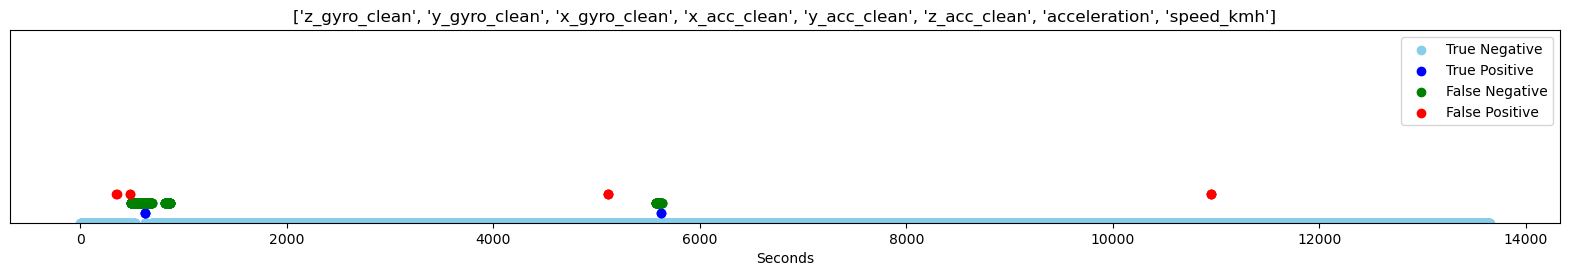

In [60]:
pred = model.predict(X_test).flatten() 
print(pred.shape, y_test.shape)
w = 5 # window in seconds
pred = np.convolve(pred, np.ones(w), mode='same') / w >= 0.5

print(pred.shape, y_test.shape)
df = pd.DataFrame(np.stack((y_test, pred)).T, columns=['true', 'pred'])
df.pred = df.pred.astype(int)

def classify(row):
    true, pred = row.true, row.pred
    if true == pred and true == 0:
        return 'True Negative'
    elif true == pred and true == 1:
        return 'True Positive'
    elif true != pred and true == 0:
        return 'False Positive'
    else:
        return 'False Negative'
    
df['type'] = df.apply(lambda x: classify(x), axis=1)
types = df.type.value_counts().sort_index()[::-1]
print(types)

fig, ax = plt.subplots(figsize=(20, 2.5))
i = 0
colors = ['skyblue', 'blue', 'green', 'red']
types_ = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for j, t in enumerate(types_):
    try:
        ax.scatter(df[df.type==t].index, [i]*types[t], label=t, c=colors[j])
    except KeyError:
        print(f'There is no {t}')
    i += 0.1

ax.legend()
ax.set_ylim(0, 2)
ax.set_xlabel('Seconds')
ax.get_yaxis().set_visible(False)
ax.set_title(f'{features[str(label)]}')